<a href="https://colab.research.google.com/github/nehcx/misalignVis/blob/master/ccls_replication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 | Requirements

In [16]:
!git clone -b master --depth=1 --recursive https://github.com/nehcx/misalignVis

Cloning into 'misalignVis'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 58 (delta 5), reused 36 (delta 2), pack-reused 0
Unpacking objects: 100% (58/58), 23.52 MiB | 3.43 MiB/s, done.
Updating files: 100% (49/49), done.
Submodule 'data/hachidaishu' (https://github.com/yamagen/hachidaishu) registered for path 'data/hachidaishu'
Cloning into '/content/misalignVis/src/misalignVis/data/hachidaishu'...
remote: Enumerating objects: 64, done.        
remote: Counting objects: 100% (64/64), done.        
remote: Compressing objects: 100% (53/53), done.        
remote: Total 64 (delta 17), reused 52 (delta 10), pack-reused 0        
Submodule path 'data/hachidaishu': checked out 'a0aaf7e0a42689db7ad2a78ab2eef9d5ac22341c'


In [17]:
import os
os.chdir('/content/misalignVis')
print(os.getcwd())

/content/misalignVis


In [18]:
# !apt-get install -y python-igraph 
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
!apt-get install graphviz libgraphviz-dev
!pip install pygraphviz
!pip install dash jupyter-dash

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.42.2-3build2).
libgraphviz-dev is already the newest version (2.42.2-3build2).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
!make build_bitext  # make bitexts.csv
#!make build_metacode2lemma_dict  # make metacode2lemma dictionary
!make train_save_ibm2  # train and save ibm model 2
!make save_db 

cd src;	python make_bitext.py -s ../data/hachidaishu/hachidai.db -t ../data/translations/all_translations.txt -o ../cache/bitexts.csv
2023-05-25 17:38:38,464 [INFO] args: Namespace(src_path='../data/hachidaishu/hachidai.db', tar_path='../data/translations/all_translations.txt', out_path='../cache/bitexts.csv')
2023-05-25 17:38:38,464 [INFO] Loading ../data/hachidaishu/hachidai.db for Kokinwakashu texts...
2023-05-25 17:38:52,558 [INFO] Loading ../data/translations/all_translations.txt for kaneko's traslation...
2023-05-25 17:39:17,879 [INFO] Loading ../data/translations/all_translations.txt for katagiri's traslation...
2023-05-25 17:39:38,404 [INFO] Loading ../data/translations/all_translations.txt for kojimaarai's traslation...
2023-05-25 17:39:59,703 [INFO] Loading ../data/translations/all_translations.txt for komachiya's traslation...
2023-05-25 17:40:19,820 [INFO] Loading ../data/translations/all_translations.txt for kubota's traslation...
2023-05-25 17:40:38,391 [INFO] Loading ../

In [21]:
!cp data/metacode2en.pkl cache/metacode2lemma_tar.pkl

# 2 | Dashboard

In [22]:
import subprocess
os.chdir('/content/misalignVis/src')
print(os.getcwd())

/content/misalignVis/src


In [ ]:
metacode2lemma_map_tar

In [33]:
"""Dash board."""
import pandas as pd
from plotly.graph_objs import Scatter, Layout, Figure
from plotly.graph_objs.layout import XAxis, YAxis, Margin
from jupyter_dash import JupyterDash
from dash import dcc, html, dash_table
from dash.dependencies import Input, Output, State
from bitexts import AlignmentInfo
from utils import load_pickle, lemma2metacode
from visualize_indivisual import draw_plotly_by_translator_by_poem
from visualize_aggregate_translator import draw_plotly_by_translator
from visualize_alignment import query, alignment_table, visualize_heatmap 

fullname2id_map = {
    "[KNK/金子] Kaneko, Motoomi (1933)": "kaneko",
    "[KBT/窪田] Kubota, Utsubo (1960)": "kubota",
    "[MTD/松田] Matsuda, Takeo (1968)": "matsuda",
    "[OZW/小沢] Ozawa, Masao (1971)": "ozawa",
    "[TKOK/竹岡] Takeoka, Masao (1976)": "takeoka",  
    "[OKMR/奥村] Okumura, Tsuneya (1978)": "okumura",
    "[KSJ/久曽神] Kyusojin, Hitachi (1979)": "kyusojin",
    "[KMCY/小町谷] Komachiya, Teruhiko (1982)": "komachiya",
    "[K&A/小島・新井] Kojima, Noriyuki and Arai, Eizo (1989)": "kojimaarai",
    "[KTGR/片桐] Katagiri, Yoichi (1998)": "katagiri",
}
translator_lst = fullname2id_map.keys()
metacode2lemma_map_src = load_pickle("../cache/metacode2lemma_src.pkl")
word_lst = [k + ":" + v  for k, v in metacode2lemma_map_src.items() if
            v in ["梅", "女郎花", "菊", "桜", "松", "山吹"]]
word_lst.sort()
with open("../README-app.md", 'r') as f: 
    readme = f.read()

def _blank(width, height, text, font_size): 
    Xn = [0]
    Yn = [0]
    trace = Scatter(
        x=Xn,
        y=Yn,
        mode="text",
    )
    annotation = text
    data = [trace]
    axis = dict(
        showline=False, 
        zeroline=False,
        showgrid=False,
        showticklabels=False,
        title="",
    )
    layout = Layout(
        # title=title,
        paper_bgcolor="rgba(0,0,0,0)",
        plot_bgcolor="rgba(0,0,0,0)",
        font=dict(size=16),
        showlegend=False,
        autosize=True,
        width=width,
        height=height,
        xaxis=XAxis(axis),
        yaxis=YAxis(axis),
        margin=Margin(
            l=0,
            r=0,
            b=85,
            t=40,
        ),
        hovermode="closest",
        annotations=
[
            dict(
                showarrow=False,
                text=annotation,
                xref="paper",
                yref="paper",
                x=0,
                y=0,
                xanchor="left",
                yanchor="bottom",
                font=dict(size=font_size),
            )
        ],
    )

    fig = Figure(data=data, layout=layout)
    return fig

app = JupyterDash(
    __name__,
    meta_tags=[
        {
            "name": "viewport", 
            "content": "width=device-width, initial-scale=1"
        }
    ],
)

app.layout = html.Div(
    children=[
        # title
        html.H1(
            children="""
            Dashboard for visualizing word alignment and misalignment between 
            classical poetic Japanese and its contemporary translations
            """,
        ),
        # query and intro
        dcc.Tabs(
            id="intro-and-query-tabs",
            value="what-is",
            parent_className="custom-tabs",
            className="custom-tabs-container",
            children=[
                dcc.Tab(
                    label="About",
                    value="what-is",
                    className="custom-tab",
                    selected_className="custom-tab--selected",
                    children=html.Div(
                        className="control-tab",
                        children=[
                            dcc.Markdown(readme),
                        ],
                    ),
                ),
                dcc.Tab(
                    label="Query",
                    value="alignment-tab-select",
                    className="custom-tab",
                    selected_className="custom-tab--selected",
                    children=html.Div(
                        className="app-controls-block",
                        children=[
                            # query word and translator
                            html.Div(
                                [
                                    html.Br(),
                                    html.Div([
                                        html.Label("Word:"),
                                        dcc.Dropdown(
                                            id="target",
                                            options=[
                                                {"label": i, "value": i} 
                                                for i in word_lst
                                            ],
                                            value="BG-01-5520-05-0106:女郎花",
                                            multi=False,
                                        ),
                                    ],
                                             style={
                                                 "width": "45%", 
                                                 "display": "inline-block",
                                             }
                                             ),

                                    html.Div([
                                        html.Label("Translator:"),
                                        dcc.Dropdown(
                                            id="translator",
                                            options=[
                                                {"label": i, "value": i} 
                                                for i in translator_lst
                                            ],
                                            value="[KNK/金子] Kaneko, Motoomi (1933)",
                                            multi=False,
                                        ),
                                    ],
                                             style={
                                                 "width": "45%", 
                                                 "float": "right", 
                                                 "display": "inline-block",
                                             }
                                             ),
                                ],
                            ),
                            # query specific poem
                            html.Br(),
                            html.Div(
                                [
                                    html.Label(
                                        """
                                        Query results (click cell to visualize 
                                        alignment and collective misalignment 
                                        network of the bitext on the selected 
                                        row):
                                        """
                                    ),
                                    dash_table.DataTable(
                                        id="datatable-paging",
                                        columns=[
                                            {"name": i, "id": i} for i in 
                                            ["poem", "queried word", 
                                             "source text", "target text"]
                                        ],
                                        page_current=0,
                                        page_size=3,
                                        page_action="custom",
                                        style_cell_conditional=[
                                            {"if": {"column_id": "target text"},                                        
                                             "width": "0%"},
                                            {"if": {"column_id": "source text"},                                        
                                             "width": "70%"},
                                            {"if": {"column_id": "poem"},                                        
                                             "width": "10%"},
                                            {"if": {"column_id": "queried word"},                                        
                                             "width": "20%"},
                                        ],
                                        style_cell={
                                            "overflow": "hidden",
                                            "textOverflow": "ellipsis",
                                            "maxWidth": 0,
                                        },
                                    ),
                                ],
                            ),
                        ],
                    ),
                ),
            ],
        ),

        html.Br(),
        dcc.Tabs(
            id="result-tabs",
            value="network-tab-select",
            parent_className="custom-result-tabs",
            className="custom-result-tabs-container",
            children=[
                dcc.Tab(
                    label="Word alignment visualization",
                    value="alignment-tab-select",
                    className="custom-tab",
                    selected_className="custom-tab--selected",
                    children=html.Div(
                        className="result-tab",
                        children=[
                            html.Div(
                                dcc.Graph(id="alignment-graph"),
                                style={
                                    "width": "100%", 
                                    "display": "inline-block",
                                },
                            ),
                        ],
                    ),
                ),

                # html.Hr(),
                dcc.Tab(
                    label="Collective misalignment network visualization",
                    value="network-tab-select",
                    className="custom-tab",
                    selected_className="custom-tab--selected",
                    children=html.Div(
                        className="result-tab",
                        children=[ 
                            html.Br(),
                            html.Div(
                                [
                                    html.Div(
                                        [
                                            # html.Label("Selected poem"),
                                            dcc.Graph(
                                                id="individual-network-graph"
                                            ), 
                                        ],       
                                        style={
                                            "width": "50%", 
                                            "float": "left", 
                                            "display": "inline-block",
                                        },
                                    ),

                                    html.Div(
                                        [
                                            # html.Label("All queried poems"),
                                            dcc.Graph(
                                                id="translator-network-graph"
                                            ), 
                                        ],       
                                        style={
                                            "width": "50%", 
                                            "float": "right", 
                                            "display": "inline-block",
                                        },
                                    ),
                                ],
                            ),
                        ],
                    ),
                ),
            ],
        ),
    ],
                      )


# Data table
@app.callback(
    [Output("datatable-paging", "page_current"),
     Output("datatable-paging", "page_count"),
     Output("datatable-paging", "data")],
    [Input("datatable-paging", "page_current"),
     Input("datatable-paging", "page_size"),
     Input("target", "value"),
     Input("translator", "value")],
    [State("datatable-paging", "data")]
)
def update_table(page_current, page_size, target, translator, table_data):
    target, word = target.split(":")
    translator = fullname2id_map[translator]
    candidates = query(target, translator)
    page_count = len(candidates) // page_size + 1
    candidate_df = pd.DataFrame({
        "poem": [candidate.poem for candidate in candidates],
        "source text": [candidate.source_surface for candidate in candidates],
        "target text": [candidate.target_surface for candidate in candidates],
        "queried word": [word for candidate in candidates],
    })
    data = candidate_df.iloc[
        page_current*page_size:(page_current+1)*page_size
    ].to_dict("records")
    if table_data is not None:
        try: 
            table_data[0]
        except:
            page_current = page_count - 1
    return page_current, page_count, data


# Alignment visualization and individual poem network visualization
@app.callback(
    [Output("alignment-graph", "figure"),
     Output("individual-network-graph", "figure")],
    [Input("datatable-paging", "active_cell"),
     Input("datatable-paging", "page_current"),
     Input("datatable-paging", "page_size"),
     Input("translator", "value"),
     Input("target", "value")],
    [State("datatable-paging", "data")]
)
def update_alignment_and_individual_network_graph(
        active_cell, page_current, page_size, 
        translator, target, table_data):
    try:
        target, word = target.split(":")
        translator = fullname2id_map[translator]
        if active_cell:
            row = active_cell["row"]
            queied_word = table_data[row]["queried word"]
            if queied_word == word:
                idx = table_data[row]["poem"]
                text = table_data[row]["source text"]
            else:
                candidates = query(target, translator)    
                current_candidate = candidates[page_current*page_size]    
                idx = current_candidate.poem
                text = current_candidate.source_surface
        else:
            candidates = query(target, translator)    
            current_candidate = candidates[page_current*page_size]    
            idx = current_candidate.poem
            text = current_candidate.source_surface
        _, heatmap, targets = alignment_table(idx, translator, target)
        fig_alignment = visualize_heatmap(heatmap, targets)
        fig_alignment.update_layout(transition_duration=500)
        fig_individual_network = draw_plotly_by_translator_by_poem(target, idx)
        fig_individual_network.update_layout(
            title = f"<span style='font-size: 14px;'>{target} {word}</span>" + 
            "<br>" +
            f"<span style='font-size: 10px;'>{text} -古今{idx}</span>"
        )
        fig_individual_network.update_layout(transition_duration=500)
        return fig_alignment, fig_individual_network
    except:
        return (_blank(1000, 600, "Queried word was not found.", 12),
                _blank(500, 600, "Queried word was not found.", 12))


# Global network visualization
@app.callback(
    Output("translator-network-graph", "figure"),
    [Input("target", "value")]
)
def update_translator_network(target):
    try:
        target = target.split(":")[0]
        fig = draw_plotly_by_translator(target)
        fig.update_layout(transition_duration=500)
        return fig
    except:
        return _blank(500, 600, "Queried word was not found.", 12)

In [34]:
app.run_server(mode='inline')

<IPython.core.display.Javascript object>

# 3 | Visualization by Graphviz


## 3.1 | Aggregate Visualization

In [25]:
import subprocess

os.chdir('/content/misalignVis/src')
print(os.getcwd())

/content/misalignVis/src


In [26]:
import re
import igraph as ig
from dataclasses import astuple, asdict
from utils import load_pickle, lemma2metacode
import bitexts
from bitexts import AlignmentInfo
import math
from IPython.display import SVG

In [27]:
DB = load_pickle("../cache/bitexts.db")
translator_lst = DB.translators
metacode2lemma_map_src = load_pickle("../cache/metacode2lemma_src.pkl")
metacode2lemma_map_tar = load_pickle("../cache/metacode2lemma_tar.pkl")
romaji2kanji_map = {
    "kaneko": "KNK",
    "katagiri": "KTGR",
    "kojimaarai": "K&A",
    "komachiya": "KMCY",
    "kubota": "KBT",
    "kyusojin": "KSJ",
    "matsuda": "MTD",
    "okumura": "OKMR",
    "ozawa": "OZW",
    "takeoka": "TKOK"
}

In [36]:
def _gen_graph(alignment_summary, edge_info, source_words, source_word_translator_set, target_word_set):

    # Edge by translator generator
    def edge_by_translator():
        for stat in alignment_summary.summary:
            source_word = stat.alignment[0]
            target_word = stat.alignment[1]
            stat = asdict(stat)
            for (key, value) in stat.items():
                if (key == "alignment") or (key == "total"):
                    continue
                source_node = f"{source_word}-{key}"
                target_node = target_word
                weight = value
                if weight == 0:
                    continue
                yield (source_node, target_node, weight, 8)

    # Aligned target word generator
    def target_words():
        for info in edge_info:
            target_word = info.alignment[1]
            if target_word in target_word_set:
                continue
            target_word_set.add(target_word)
            yield target_word

    # Source word with translator coding generator
    def source_words_by_translator():
        for word in source_words:
            info_lst = alignment_summary.query_details_by_source(word)
            for info in info_lst:
                word = info.word
                translator = info.translator
                name = (word, translator)
                if name in source_word_translator_set:
                    continue
                source_word_translator_set.add(name)
                yield name

    # Source word node generator
    def source_nodes():
        for row in source_words_by_translator():
            source_word = row[0]
            translator = row[1]
            name = source_word + "-" + translator
            node = f"{metacode2lemma_map_src[source_word]}\n({romaji2kanji_map[translator]})"
            node_type = 1
            type_label = "source"
            weight = 0
            shape = "ellipse"
            info_lst = alignment_summary.query_details_by_source(row[0])
            for info in info_lst:
                if info.translator != row[1]:
                    continue
                weight += 1
            yield (name, node, node_type, type_label, weight, shape)

    # Target word node generator
    def target_nodes():
        for word in target_words():
            name = word
            node = f"{metacode2lemma_map_tar[word]}"
            node_type = 2
            type_label = "target"
            weight = 0
            shape = "rectangle"
            info_lst = alignment_summary.query_details_by_target(word)
            for info in info_lst:
                weight += 1
                source_metacode = info.alignment[0].split("-")
                target_metacode = info.alignment[1].split("-")
                if source_metacode[:4] == target_metacode[:4]:
                    node_type = 3
                    type_label = "dublicate"
            yield (name, node, node_type, type_label, weight, shape)

    # Igraph construction
    node_lst = list(source_nodes()) + list(target_nodes())
    node_lst = sorted(node_lst, key=lambda x: (x[2], x[4]), reverse=True)
    edge_lst = list(edge_by_translator())
    edge_lst = sorted(edge_lst, key=lambda x: (x[1], x[2]), reverse=True)
    graph = ig.Graph.TupleList(edge_lst, directed=False, edge_attrs=["label", "fontsize"])

    for node_attr in node_lst:
        name, node, node_type, type_label, weight, shape = node_attr
        for v in graph.vs:
            if v["name"] != name:
                continue
            v["label"] = node
            v["node_type"] = node_type
            v["type_label"] = type_label
            if weight >= 5:
                v["style"] = "filled"
                v["fillcolor"] = "lightyellow"
            if node_type == 1:
                v["style"] = "filled"
                v["fillcolor"] = "lightgrey"
                v["width"] = 0.1
                v["fontsize"] = 8
            else:
                v["fontsize"] = (math.log(weight+7)) * 5
            v["shape"] = shape
    return graph

def _filter(alignment_info_lst):
    """To remove edges that contain the same nodes with source nodes and stop pos."""
    for alignment_info in alignment_info_lst:
        source, target = alignment_info.alignment
        # BG-16: symbols
        # BG-0[456789]: words that are not nouns, verbs or adjectives
        # BG-03-1000: demonstratives
        pattern = re.compile(r'BG-16|BG-0[456789]|BG-03-1000')
        if pattern.match(target):
            continue
        if source[3:15] == target[3:15]:
            continue
        yield alignment_info


def retrive_igraph_by_translator(*source_words):
    """Retrive igraph format data with translator attension.

    :return graph: igraph-converted information.
    """
    target_word_set = set()
    source_word_translator_set = set()
    alignment_lst = DB.query_improper_alignment_by_word(*source_words)    
    alignment_lst = list(_filter(alignment_lst))
    alignment_summary = bitexts.AlignmentSummary(alignment_lst)
    edge_info = alignment_summary.alignment_info  # For edges' annotation

    return _gen_graph(alignment_summary, edge_info, source_words, source_word_translator_set, target_word_set)

In [37]:
def dot_viz_aggr(word, width=None):
    code = lemma2metacode(word, metacode2lemma_map_src)
    g = retrive_igraph_by_translator(code)
    g.write_dot(f"../artifacts/{word}.dot")
    if width:
        with open(f"../artifacts/{word}.dot", "r") as file:
            lines = file.readlines()

        # attr
        lines.insert(2, f'  size="{width},";\n')
        lines.insert(3, '  ratio="fill";\n')

        # lines.insert(4, '  mode="ipsep";\n')
        # lines.insert(5, '  sep=1;\n')
        # lines.insert(6, '  overlap=false;\n')
        
        with open(f"../artifacts/{word}.dot", "w") as file:
            file.writelines(lines)
    neato_command = f"neato -Tsvg ../artifacts/{word}.dot -o ../artifacts/{word}.svg"
    subprocess.run(neato_command, shell=True, check=True)
    display(SVG(filename=f"../artifacts/{word}.svg")) 

### 3.2 | Examples

#### 3.2.1 | *Ume*, en. plum

Lemma has the following semantic codings:
 1: BG-01-5520-20-0401
 2: BG-01-5520-20-0402
Input one ID to query:1


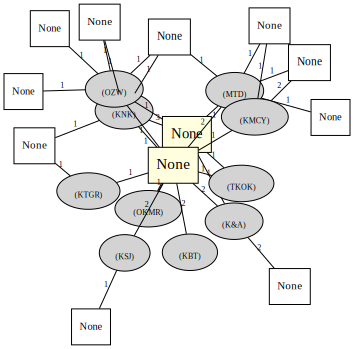

In [38]:
dot_viz_aggr("梅")

#### 3.2.2 | *Ominaeshi*, en. golden valerian

In [ ]:
dot_viz_aggr("女郎花")

#### 3.2.3 | *Kiku*, en. chrysanthemum

In [ ]:
dot_viz_aggr("菊")

#### 3.2.4 | *Sakura*, en. cherry

In [ ]:
dot_viz_aggr("桜")

#### 3.2.5 | *Matsu*, en. pine

In [ ]:
dot_viz_aggr("松")

#### 3.2.6 | *Yamabuki*, en. kerria

In [ ]:
dot_viz("山吹")

## 3.2 | Breakdown Visualization

In [ ]:
def retrive_igraph_by_poem_by_translator(idx: str, *source_words):
    """Retrive igraph format data from one poem with a translator attension.

    :return graph: igraph-converted information.
    """
    target_word_set = set()
    source_word_translator_set = set()
    alignment_lst = DB.query_improper_alignment_by_word_in_poem(idx, *source_words)    
    alignment_lst = list(_filter(alignment_lst))
    alignment_summary = bitexts.AlignmentSummary(alignment_lst)
    edge_info = alignment_summary.alignment_info  # For edges" annotation
    
    return _gen_graph(alignment_summary, edge_info, source_words, source_word_translator_set, target_word_set)

In [ ]:
def dot_viz_brkd(word, width=None):
    code = lemma2metacode(word, metacode2lemma_map_src)
    candidates = DB.query_bitext_by_word(code)
    poems = {}
    candidates = DB.query_bitext_by_word(code)
    for candidate in candidates:
        if candidate.poem in poems.keys():
            break
        poems[candidate.poem] = candidate.source_surface
        print(candidate.poem, candidate.source_surface)
    idx = str(input("Input poem id: "))
    print(idx, poems[idx])
    query = DB.query_by_poem(idx)
    for candidate in query:
        print(candidate.translator, candidate.target_surface)

    g = retrive_igraph_by_poem_by_translator(idx, code)
    g.write_dot(f"../artifacts/{idx}-{word}.dot")
    if width:
        with open(f"../artifacts/{idx}-{word}.dot", "r") as file:
            lines = file.readlines()

        # attr
        lines.insert(2, f'  size="{width},";\n')
        lines.insert(3, '  ratio="fill";\n')
        # lines.insert(4, '  mode="ipsep";\n')
        # lines.insert(5, '  sep=1;\n')
        # lines.insert(6, '  overlap=false;\n')

        with open(f"../artifacts/{word}.dot", "w") as file:
            file.writelines(lines)

    neato_command = f"neato -Tsvg ../artifacts/{idx}-{word}.dot -o ../artifacts/{idx}-{word}.svg"
    subprocess.run(neato_command, shell=True, check=True)
    display(SVG(filename=f"../artifacts/{idx}-{word}.svg")) 

#### 3.2.1 | Example

In [ ]:
dot_viz_brkd("女郎花")